In [19]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import os, sys

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.voxel_size = 32

        self.main = nn.Sequential(

		    nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm3d(32, momentum=0.8),

            nn.Conv3d(32, 64, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm3d(64, momentum=0.8),
            nn.LeakyReLU(0.2), ## inplace = True

            nn.Conv3d(64, 128,  kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm3d(128, momentum=0.8),
            nn.LeakyReLU(0.2),

            nn.Conv3d(128, 512, 1, 2, padding=0, bias=False),
            nn.BatchNorm3d(512, momentum=0.8),
            nn.LeakyReLU(0.2),

            nn.Dropout(p=0.5),

            ## Decoder
            # nn.Upsample(scale_factor=2),
            nn.ConvTranspose3d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm3d(256, momentum=0.8),

            nn.ConvTranspose3d(256, 128, 4,  2, 1),
            nn.ReLU(),
            nn.BatchNorm3d(128, momentum=0.8),

            # nn.Upsample(scale_factor=2),
            nn.ConvTranspose3d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm3d(64, momentum=0.8),

            # nn.Upsample(scale_factor=2),
            nn.ConvTranspose3d(64, 1, 4, 2, 1), # in_ch, out_ch, kernelsize, stride, padding, 
            nn.ReLU(),
            nn.Tanh(),
        )

    def forward(self, x):
        # for layer in self.main:
        #     x=layer(x)
        #     print(x.size())
        # x = x.view(x.size(0), -1)
        return self.main(x)

In [89]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
       torch.nn.Conv3d(1, 32, 4, 2, 1),
    nn.BatchNorm3d(32, momentum=0.8),
    nn.LeakyReLU(0.2),

    nn.Conv3d(32, 64, 4, 2, 1),
    nn.BatchNorm3d(64, momentum=0.8),
    nn.LeakyReLU(0.2),

    nn.Conv3d(64, 128, 4, 2, 1),
    nn.BatchNorm3d(128, momentum=0.8),
    nn.LeakyReLU(0.2),

    nn.Conv3d(128, 256, 4, 2, 1),
    nn.BatchNorm3d(256, momentum=0.8),
    nn.LeakyReLU(0.2),

    nn.Flatten(),
    nn.Linear(2048, 1),
    nn.Sigmoid()   
        )

    def forward(self, x):
        for layer in self.main:
            x=layer(x)
            print(x.size())
        # x's size: batch_size * 1 * 64 * 64 * 64
        x = self.main(x)
        # return self.main(x) 
        return x.view(-1, x.size(1)) # .view reshape it to 1 column


In [22]:
def mkdirs(dir):
    dir=os.path.abspath(dir)
    if not os.path.exists(dir):
        os.makedirs(dir)

In [23]:
IMAGE_DIR = './32_cube/images'
MODEL_DIR = './32_cube/saved_model'

In [24]:
class Wall():
    def __init__(self, voxel_size=32):

        self.vol_rows = voxel_size
        self.vol_cols = voxel_size
        self.vol_height = voxel_size
        self.mask_height = int(self.vol_rows*3/4)
        self.mask_width = int(self.vol_cols*3/4)
        self.mask_length = int(self.vol_height*3/4)
        self.channels = 1
        self.num_classes = 2
        self.vol_shape = (self.vol_rows, self.vol_cols, self.vol_height, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.mask_length, self.channels)
        # self.missing_shape = (self.vol_rows, self.vol_cols, self.vol_height, self.channels)
       
    def generateWall(self):
        x, y, z = np.indices((self.vol_rows, self.vol_cols, self.vol_height))
        voxel = (x < self.vol_rows-3) & (x > 3) & (y > 3) & (y < self.vol_cols-3) & (z > 5) & (z <self.vol_height-5)
        # add channel
        voxel = voxel[..., np.newaxis].astype(np.float)
        # repeat 1000 times
        voxels = list()
        for i in range(1000):
            voxels.append(voxel)
        voxels = np.asarray(voxels)
        return voxels

    def mask_randomly(self, vols):
        y1 = np.random.randint(0, self.vol_rows - self.mask_height, vols.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.vol_cols - self.mask_width, vols.shape[0])
        x2 = x1 + self.mask_width
        z1 = np.random.randint(0, self.vol_height - self.mask_length, vols.shape[0])
        z2 = z1 + self.mask_length

        masked_vols = np.empty_like(vols)
        missing_parts = np.empty_like(vols) #np.empty((vols.shape[0], self.vol_height, self.vol_cols, self.vol_rows, self.channels))

        for i, vol in enumerate(vols):
            masked_vol = vol.copy()
            _y1, _y2, _x1, _x2, _z1, _z2 = y1[i], y2[i], x1[i], x2[i], z1[i], z2[i]
            # missing_parts[i] = masked_vol[_y1:_y2, _x1:_x2, _z1:_z2, :].copy()
            masked_vol[_y1:_y2, _x1:_x2, _z1:_z2, :] = 0
            masked_vols[i] = masked_vol
            
            missing_parts[i] = vol.copy() - masked_vol.copy() 
#             missing_parts[_y1:_y2, _x1:_x2, _z1:_z2, :] = 1

        return masked_vols, missing_parts, (y1, y2, x1, x2, z1, z2)

In [34]:
X_train = Wall().generateWall()
print(X_train.shape)

# masked_vols, missing_parts, _ = Wall().mask_randomly(X_train[0:16])

# fig = plt.figure()
# fig = plt.figure(figsize=plt.figaspect(0.3))
# ax1 = fig.add_subplot(131, title='masked volume', projection='3d')
# ax2 = fig.add_subplot(132, title='valid missing', projection='3d') 
# # ax3 = fig.add_subplot(133, title='gen missing', projection='3d') 

# ax1.voxels(masked_vols[10].reshape((32,32,32)).reshape((32,32,32)), facecolors='blue', edgecolor='k')
# ax2.voxels(missing_parts[10].reshape((32,32,32)), facecolors='green', edgecolor='k')
# # ax3.voxels(gen_missing[0].to('cpu').detach().numpy().reshape((32,32,32)), facecolors='red', edgecolor='k')
# plt.show()

(1000, 32, 32, 32, 1)


In [93]:
batch_size = 16
epochs = 1000
sample_interval = 10

valid = torch.ones((batch_size, 1)).cuda(0)
fake = torch.zeros((batch_size, 1)).cuda(0)

G = Generator().cuda(0)
D = Discriminator().cuda(0)

## set BCE loss
criterion = nn.BCELoss()

D_solver = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
test = nn.

In [92]:
G_losses = []
D_losses = []

for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    vols = X_train[idx]
    masked_vols, missing_parts, _ = Wall().mask_randomly(vols)

    # train discriminator
    vols =  torch.from_numpy(vols.transpose(0, 4, 1,2,3)).cuda(0).to(dtype=torch.float)
    print("vol shape", vols.shape)
    masked_vols = torch.from_numpy(masked_vols.transpose(0, 4, 1,2,3)).cuda(0).to(dtype=torch.float)
    # missing_parts = torch.from_numpy(missing_parts.transpose(0, 4, 1,2,3)).cuda(0).to(dtype=torch.float)
    d_real = D(vols)
    d_loss_real = criterion(d_real, valid)

    gen_vol = G(masked_vols)
    d_fake = D(gen_vol.detach()) # avoid backward propagation
    d_loss_fake = criterion(d_fake, fake)
    d_loss = 0.5*(d_loss_real + d_loss_fake)
    
    d_real_acu = torch.ge(d_real.squeeze(), 0.5).float()
    d_fake_acu = torch.le(d_fake.squeeze(), 0.5).float()
    d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))

    if d_total_acu <= 0.8:
#         print("d updated", d_total_acu)
        D_solver.zero_grad()
        d_loss.backward()
        D_solver.step()
    
    # print("d_loss", d_loss_real.to('cpu').detach().numpy(), d_loss_fake.to('cpu').detach().numpy(), d_loss.to('cpu').detach().numpy())


    # train generator
    G_solver.zero_grad()
#     D.zero_grad()
    gen_vol = G(masked_vols)
    d_fake = D(gen_vol)
    g_loss = criterion(d_fake, valid) # better to be bigger
    g_loss.backward()
    G_solver.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
    print(epoch, "d_loss", d_loss.to('cpu').detach().numpy(), "g_loss", g_loss.to('cpu').detach().numpy() )

    if epoch % 10 == 0:
        fig = plt.figure()
        fig = plt.figure(figsize=plt.figaspect(0.3))
        ax1 = fig.add_subplot(131, title='masked volume', projection='3d')
        ax2 = fig.add_subplot(132, title='valid missing', projection='3d') 
        ax3 = fig.add_subplot(133, title='gen missing', projection='3d') 

        ax1.voxels(masked_vols[0].reshape((32,32,32)), facecolors='blue', edgecolor='k')
        ax2.voxels(missing_parts[0].reshape((32,32,32)), facecolors='green', edgecolor='k')
        gen_vol = gen_vol.to('cpu').detach().numpy()
        print("shape gen vol", gen_vol)
        gen_vol = np.where(gen_vol > 0.5, 1, 0)
        ax3.voxels(gen_vol[0], facecolors='red', edgecolor='k')
        plt.show()



    if epoch % sample_interval*10 == 0:
        g_model_path = os.path.join(MODEL_DIR, "G")
        torch.save(G.state_dict(), g_model_path)
        d_model_path = os.path.join(MODEL_DIR, "D")
        torch.save(D.state_dict(), g_model_path)
        np.save("32_cube/losses", np.array(G_losses), np.array(D_losses))
           

    

vol shape torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 32, 16, 16, 16])
torch.Size([16, 32, 16, 16, 16])
torch.Size([16, 32, 16, 16, 16])
torch.Size([16, 64, 8, 8, 8])
torch.Size([16, 64, 8, 8, 8])
torch.Size([16, 64, 8, 8, 8])
torch.Size([16, 128, 4, 4, 4])
torch.Size([16, 128, 4, 4, 4])
torch.Size([16, 128, 4, 4, 4])
torch.Size([16, 256, 2, 2, 2])
torch.Size([16, 256, 2, 2, 2])
torch.Size([16, 256, 2, 2, 2])
torch.Size([16, 2048])
torch.Size([16, 1])
torch.Size([16, 1])


RuntimeError: Expected 5-dimensional input for 5-dimensional weight [32, 1, 4, 4, 4], but got 2-dimensional input of size [16, 1] instead

In [29]:
losses = open("32_cube/losses_1.txt", mode="r")
g_loss = []
d_loss = []
for line in losses:
    # print(line)
    g_loss.append(line.split(" ")[2])
    d_loss.append(line.split(" ")[4])
# print(g_loss, d_los

No handles with labels found to put in legend.


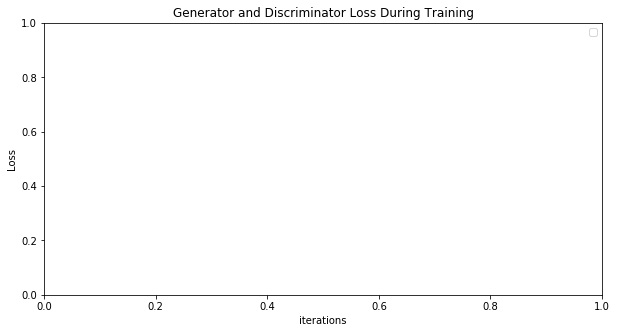

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
# plt.plot(g_loss,label="G")
# plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("g_d_losses.png")

In [31]:
# D = Discriminator().cuda(0)
# # m = nn.Conv3d(1, 32, 4, 2, 1).cuda(0)
# # m(X).shape
# D_X = D(X)
# print(D_X.shape, D_X)

In [32]:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #
# =================================================================
# conv3d_1 (Conv3D)            (None, 16, 16, 16, 32)    4032
# _________________________________________________________________
# leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 16, 32)    0
# _________________________________________________________________
# batch_normalization_1 (Batch (None, 16, 16, 16, 32)    128
# _________________________________________________________________
# conv3d_2 (Conv3D)            (None, 8, 8, 8, 64)       256064
# _________________________________________________________________
# leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 8, 64)       0
# _________________________________________________________________
# batch_normalization_2 (Batch (None, 8, 8, 8, 64)       256
# _________________________________________________________________
# conv3d_3 (Conv3D)            (None, 4, 4, 4, 128)      1024128
# _________________________________________________________________
# leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 4, 128)      0
# _________________________________________________________________
# batch_normalization_3 (Batch (None, 4, 4, 4, 128)      512
# _________________________________________________________________
# conv3d_4 (Conv3D)            (None, 2, 2, 2, 512)      66048
# _________________________________________________________________
# leaky_re_lu_4 (LeakyReLU)    (None, 2, 2, 2, 512)      0
# _________________________________________________________________
# dropout_1 (Dropout)          (None, 2, 2, 2, 512)      0
# _________________________________________________________________
# up_sampling3d_1 (UpSampling3 (None, 4, 4, 4, 512)      0
# _________________________________________________________________
# conv3d_transpose_1 (Conv3DTr (None, 4, 4, 4, 256)      16384256
# _________________________________________________________________
# activation_1 (Activation)    (None, 4, 4, 4, 256)      0
# _________________________________________________________________
# batch_normalization_4 (Batch (None, 4, 4, 4, 256)      1024
# _________________________________________________________________
# conv3d_transpose_2 (Conv3DTr (None, 4, 4, 4, 128)      4096128
# _________________________________________________________________
# activation_2 (Activation)    (None, 4, 4, 4, 128)      0
# _________________________________________________________________
# batch_normalization_5 (Batch (None, 4, 4, 4, 128)      512
# _________________________________________________________________
# up_sampling3d_2 (UpSampling3 (None, 8, 8, 8, 128)      0
# _________________________________________________________________
# conv3d_transpose_3 (Conv3DTr (None, 8, 8, 8, 64)       1024064
# _________________________________________________________________
# activation_3 (Activation)    (None, 8, 8, 8, 64)       0
# _________________________________________________________________
# batch_normalization_6 (Batch (None, 8, 8, 8, 64)       256
# _________________________________________________________________
# up_sampling3d_3 (UpSampling3 (None, 16, 16, 16, 64)    0
# _________________________________________________________________
# conv3d_transpose_4 (Conv3DTr (None, 16, 16, 16, 1)     8001
# _________________________________________________________________
# activation_4 (Activation)    (None, 16, 16, 16, 1)     0
# =================================================================
# Total params: 22,865,409
# Trainable params: 22,864,065
# Non-trainable params: 1,344
# _________________________________________________________________
#

In [33]:
#  Model: "sequential_2"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #
# =================================================================
# conv3d_5 (Conv3D)            (None, 8, 8, 8, 64)       1792
# _________________________________________________________________
# leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 8, 64)       0
# _________________________________________________________________
# batch_normalization_7 (Batch (None, 8, 8, 8, 64)       256
# _________________________________________________________________
# conv3d_6 (Conv3D)            (None, 4, 4, 4, 128)      221312
# _________________________________________________________________
# leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 4, 128)      0
# _________________________________________________________________
# batch_normalization_8 (Batch (None, 4, 4, 4, 128)      512
# _________________________________________________________________
# conv3d_7 (Conv3D)            (None, 4, 4, 4, 256)      884992
# _________________________________________________________________
# leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 4, 256)      0
# _________________________________________________________________
# batch_normalization_9 (Batch (None, 4, 4, 4, 256)      1024
# _________________________________________________________________
# flatten_1 (Flatten)          (None, 16384)             0
# _________________________________________________________________
# dense_1 (Dense)              (None, 1)                 16385
# =================================================================